# Intro


# Setup

In [7]:
from importlib import reload
import sys
from time import time, sleep

import numpy as np
from matplotlib import pyplot as plt

# Reload already loaded modules
for m in ("AD5522_pi", "AD7685_pi", "AD5522dev_pi"):
    try:
        mod = sys.modules[m]
    except KeyError:
        pass
    else:
        reload(mod)
from AD5522dev_pi import AD5522dev
from AD5522_pi import MeasMode

In [8]:
board = AD5522dev(vref=5.0)

We can start anew or load already existing data from disk

In [9]:
try:
    # Load data from disk to extend it
    data = np.load("SalvagedCapacitors.npz")["data"][()]
except:
    # Start anew
    data = {}

# Connection

* channel 1: pin 1
* DUTGND: pin 2

Data is added with a name and plotted for verification.

## Measurement

In [142]:
def _block(*, currentrange, chargecurrent):
    print("Measuring")
    ch = board.channels[1]
    ch.currentrange = currentrange
    board.measchannel = 1

    def _fimeasure():
        meas = [time()]
        
        ch.mode = MeasMode.FIMI
        meas.append(board.measure(count=2)[0])
        ch.mode = MeasMode.FIMV
        meas.append(board.measure(count=10)[0])
        return meas

    def _fvmeasure():
        meas = [time()]
        
        ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=10)[0])
        ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=2)[0])
        return meas

    meas = []

    # Discharge to 0V for maximum 5 seconds
    print("\tDischarge")
    ch.mode = MeasMode.FVMV
    ch.force = 0
    v = 10
    start = t = time()
    while ((-0.01 > v) or (v > 0.01)) and ((t - start) < 5.0):
        m = _fvmeasure()
        meas.append(m)
        t = m[0]
        v = m[-1]

    # Charge to 10V for maximum 10 seconds
    print("\tRise")
    ch.mode = MeasMode.HIMI
    ch.force = chargecurrent
    v = 0.0
    start = t = time()
    while (v < 10.022) and ((t - start) < 10.0):
        m = _fimeasure()
        meas.append(m)
        t = m[0]
        v = m[-1]

    # Keep voltage @ 10V for 5 seconds
    print("\tKeep")
    start = t = time()
    ch.mode = MeasMode.HVMI
    ch.force = 10.0
    ch.mode = MeasMode.FVMI
    while (t - start) < 5.0:
        m = _fvmeasure()
        meas.append(m)
        t = m[0]

    # Discharge to -10V for maxiumum 15 seconds
    print("\tFall")
    ch.mode = MeasMode.HIMI
    ch.currentrange = currentrange
    ch.force = -chargecurrent
    start = t = time()
    v = 10.0
    while (v > -10.022) and ((t - start) < 15.0):
        m = _fimeasure()
        meas.append(m)
        t = m[0]
        v = m[-1]

    # Max discharge to 0V
    ch.mode = MeasMode.FVMI
    ch.force = 0.0
    v = -10
    while (-0.01 > v) or (v > 0.01):
        m = _fvmeasure()
        meas.append(m)
        v = m[-1]

    ch.force = 0.0
    ch.mode = MeasMode.HVMV

    print("Done\n")
    return np.array(meas)

data["105K"] = _d = _block(currentrange="5µA", chargecurrent=2e-6)

Measuring
	Discharge
	Rise
	Keep
	Fall
Done



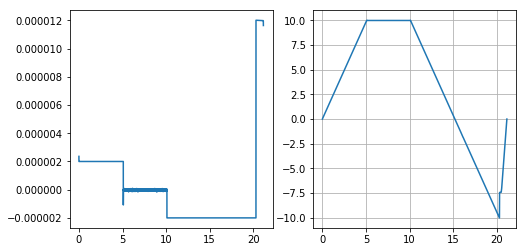

In [143]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(_d[:,0]-_d[0,0], _d[:,1])
plt.subplot(1,2,2)
plt.plot(_d[:,0]-_d[0,0], _d[:,2])
plt.grid("on")
plt.show()

In [144]:
np.savez("SalvagedCapacitors", data=data)
print("Data saved")

Data saved
